In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
train = pd.read_csv("C:/Users/86134/Desktop/train.csv")
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [3]:
train['full_text'][0]

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up and go t

In [4]:
#空格和句号作为特征值
train['chars'] = train['full_text'].str.split(' ').apply(len)
train['sents'] = train['full_text'].str.split('.').apply(len)

In [5]:
#使用Background_gradient()方法和train的cohesion作为其参数值
train[train.cohesion>1].corr().style.background_gradient()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,chars,sents
cohesion,1.000000,0.688703,0.658414,0.684918,0.632497,0.658906,0.092905,0.304475
syntax,0.688703,1.000000,0.674096,0.720966,0.704786,0.694260,0.076603,0.326032
vocabulary,0.658414,0.674096,1.000000,0.730735,0.649082,0.657664,0.107200,0.318664
phraseology,0.684918,0.720966,0.730735,1.000000,0.715697,0.661869,0.092558,0.273632
grammar,0.632497,0.704786,0.649082,0.715697,1.000000,0.668070,-0.003197,0.198628
conventions,0.658906,0.694260,0.657664,0.661869,0.668070,1.000000,0.042422,0.283785
chars,0.092905,0.076603,0.107200,0.092558,-0.003197,0.042422,1.000000,0.406132
sents,0.304475,0.326032,0.318664,0.273632,0.198628,0.283785,0.406132,1.000000


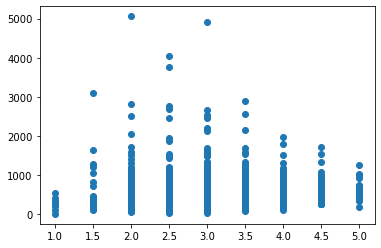

In [6]:
plt.scatter(train.cohesion, train.chars)
plt.show()

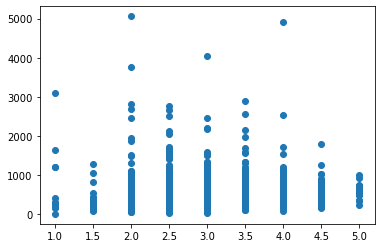

In [7]:
plt.scatter(train.syntax, train.chars)
plt.show()

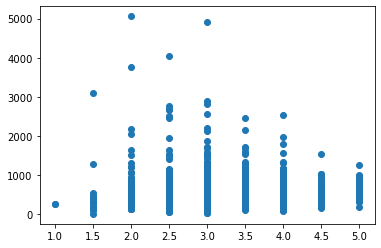

In [8]:
plt.scatter(train.vocabulary, train.chars)
plt.show()

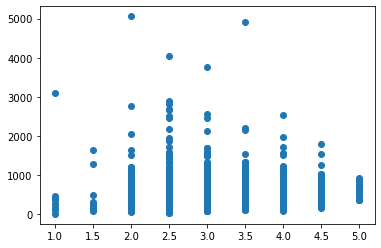

In [9]:
plt.scatter(train.phraseology, train.chars)
plt.show()

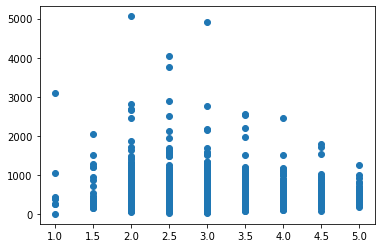

In [10]:
plt.scatter(train.grammar, train.chars)
plt.show()

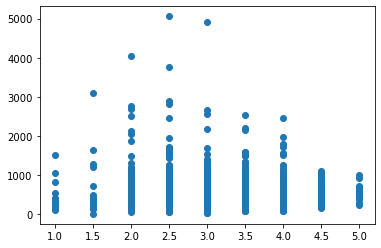

In [11]:
plt.scatter(train.conventions, train.chars)
plt.show()

In [12]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

import tensorflow as tf


import transformers

from transformers import AutoTokenizer, AutoModel
from transformers import DataCollatorWithPadding
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

from datasets import Dataset

import os
import gc
import sys
from tqdm.notebook import tqdm

In [13]:
import tensorflow_addons as tfa

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [14]:
CONFIG = {
        'folds': 5,
        'seed': 101,
        
        # Kaggle 嵌入
        'debertav3large_npy': 'C:/Users/86134/Downloads/debertav3large_FB3.npy',
        'distilrobertabase_npy': 'C:/Users/86134/Downloads/distilrobertabase_FB3.npy',
        
        'debertav3large': 'D:/deberta-v3-large',
        'distilrobertabase': 'D:/distilroberta-base',

        'batch_size': 4,
        'max_len': 512
        }

In [15]:
train = pd.read_csv("C:/Users/86134/Desktop/train.csv")
test = pd.read_csv("C:/Users/86134/Desktop/test.csv")
submission = pd.read_csv('C:/Users/86134/Desktop/sample_submission.csv')

tgtCols = ['cohesion', 'syntax', 'vocabulary','phraseology', 'grammar', 'conventions']

print(train.shape)
print(test.shape)
print(submission.shape)

(3911, 8)
(3, 2)
(3, 7)


In [16]:
import sys
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

#折叠
train["kfold"] = -1  

mskf = MultilabelStratifiedKFold(n_splits=CONFIG['folds'], shuffle=True, random_state=CONFIG['seed'])
data_labels = train[tgtCols].values

for f, (t_, v_) in enumerate(mskf.split(train, data_labels)):
    train.loc[v_, "kfold"] = f + 1

In [17]:
train['kfold'].value_counts().sort_index()

1    782
2    782
3    782
4    782
5    783
Name: kfold, dtype: int64

In [18]:
def mcrmse(y_true,y_pred):
    rmse_scores = []
    for i in range(len(tgtCols)):
        rmse_scores.append(np.sqrt(mean_squared_error(y_true[:,i],y_pred[:,i])))
    return np.mean(rmse_scores)

In [19]:
def hf_encode(texts, chkpt):
    
    tokenizer = transformers.AutoTokenizer.from_pretrained(CONFIG[chkpt])
    tokenizer.save_pretrained('./tokenizer/')

    input_ids = []
    attention_mask = []
    
    for text in texts.tolist():
        token = tokenizer(text, 
                          add_special_tokens=True, 
                          max_length=CONFIG['max_len'], 
                          return_attention_mask=True, 
                          return_tensors="np", 
                          truncation=True, 
                          padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_mask.append(token['attention_mask'][0])
    
    return np.array(input_ids, dtype="int32"), np.array(attention_mask, dtype="int32")

In [20]:
def get_dataset(df):
    inputs = hf_encode(df['full_text'])
    targets = np.array(df[tgtCols], dtype="float32")
    return inputs, targets

In [21]:
def pickle_dump(path, saveobj):
    import pickle
    filehandler = open(path,"wb")
    pickle.dump(saveobj,filehandler)
#     print("File pickled")
    filehandler.close()

In [22]:
def pickle_load(path):
    import pickle
    file = open(path,'rb')
    loadobj = pickle.load(file)
    file.close()
    return loadobj

In [23]:
class MeanPool(tf.keras.layers.Layer):
    def call(self, inputs, mask=None):
        broadcast_mask = tf.expand_dims(tf.cast(mask, "float32"), -1)
        embedding_sum = tf.reduce_sum(inputs * broadcast_mask, axis=1)
        mask_sum = tf.reduce_sum(broadcast_mask, axis=1)
        mask_sum = tf.math.maximum(mask_sum, tf.constant([1e-9]))
        return embedding_sum / mask_sum

In [24]:
def get_model(chkpt):
    
    cfg = transformers.AutoConfig.from_pretrained(CONFIG[chkpt], output_hidden_states=True)
    cfg.hidden_dropout_prob = 0
    cfg.attention_probs_dropout_prob = 0
    cfg.save_pretrained('./tokenizer/')
    
    input_ids = tf.keras.layers.Input(
        shape=(CONFIG['max_len'],), dtype=tf.int32, name="input_ids"
    )
    
    attention_masks = tf.keras.layers.Input(
        shape=(CONFIG['max_len'],), dtype=tf.int32, name="attention_masks"
    )
    
    try:
        model = transformers.TFAutoModel.from_pretrained(CONFIG[chkpt], config=cfg)
    except:
        model = transformers.TFAutoModel.from_pretrained(CONFIG[chkpt], config=cfg, from_pt=True)
        
    output = model(
        input_ids, attention_mask=attention_masks
    )
    hidden_states = output.hidden_states
    
    output = tf.stack(
        [MeanPool()(hidden_s, mask=attention_masks) for hidden_s in hidden_states[-1:]], 
        axis=2)
    
    output = tf.squeeze(output, axis=-1)
    
    model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)

    model.compile(optimizer="adam",
                 loss='huber_loss',
                 metrics=[tf.keras.metrics.RootMeanSquaredError()],
                 )
    
    return model

In [25]:
def pretrain_embeddings(chkpt, df):
    
    model = get_model(chkpt)
    dataset = hf_encode(df['full_text'], chkpt)
    preds = model.predict(dataset, batch_size=CONFIG['batch_size'])
    
    del model, dataset
    _ = gc.collect()
    
    return preds

In [26]:
train_dataset = np.load(CONFIG['debertav3large_npy'])
train_dataset = np.concatenate([train_dataset, np.load(CONFIG['distilrobertabase_npy'])], axis=1)

train_dataset.shape

(3911, 1792)

In [27]:
#RMSE均方根误差

scores = []

for fold in range(1,CONFIG['folds']):

    print('#'*25)
    print(f'## Fold {fold}')
    print('#'*25)

    trn_idx = train[train['kfold']!=fold].index.values
    val_idx = train[train['kfold']==fold].index.values

    X_train = train_dataset[trn_idx,:]
    X_valid = train_dataset[val_idx,:]

    y_train = train[train['kfold']!=fold][tgtCols].copy()
    y_valid = train[train['kfold']==fold][tgtCols].copy()

    val_preds = np.zeros((len(val_idx),6))

    for i, tgt in enumerate(tgtCols):

        print(tgt,', ',end='')
        clf = SVR(C=1)
        clf.fit(X_train, y_train[tgt].values)
        pickle_dump(f"./SVR_tgt{tgt}_fold{fold}.pkl", clf)
        val_preds[:,i] = clf.predict(X_valid)

    score = mcrmse(y_valid[tgtCols].values, val_preds)
    scores.append(score)
    print("Fold : {} RSME score: {}".format(fold,score))

    print('#'*25)
    print('Overall CV RSME =',np.mean(scores))

#########################
## Fold 1
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , Fold : 1 RSME score: 0.4574948104976473
#########################
Overall CV RSME = 0.4574948104976473
#########################
## Fold 2
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , Fold : 2 RSME score: 0.45328112992215
#########################
Overall CV RSME = 0.45538797020989863
#########################
## Fold 3
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , Fold : 3 RSME score: 0.45189874793140117
#########################
Overall CV RSME = 0.4542248961170661
#########################
## Fold 4
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , Fold : 4 RSME score: 0.45774089350556263
#########################
Overall CV RSME = 0.4551038954641903


In [28]:
del train_dataset
_ = gc.collect()

In [19]:
test_dataset = pretrain_embeddings('debertav3large', test)
test_dataset = np.concatenate([test_dataset, pretrain_embeddings('distilrobertabase', test)], axis=1)

test_dataset.shape

C:\ProgramData\Anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


(3, 1792)

In [20]:
fold_preds = []

for fold in range(1,CONFIG['folds']):

    print('#'*25)
    print(f'## Fold {fold}')
    print('#'*25)
    
    test_preds = np.zeros((len(test_dataset),6))
    for i, tgt in enumerate(tgtCols):

        print(tgt,', ',end='')
        model = pickle_load(f"./SVR_tgt{tgt}_fold{fold}.pkl")
        test_preds[:,i] = model.predict(test_dataset)
    
    fold_preds.append(test_preds)
    
    del model
    _ = gc.collect()

#########################
## Fold 1
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , #########################
## Fold 2
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , #########################
## Fold 3
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , #########################
## Fold 4
#########################
cohesion , syntax , vocabulary , phraseology , grammar , conventions , 

In [21]:
preds = np.mean(fold_preds, axis=0)
preds = np.clip(preds, 1, 5)

In [22]:
sub_df = pd.concat([test[['text_id']], pd.DataFrame(preds, columns=tgtCols)], axis=1)
sub_df.to_csv('submission.csv', index=False)

In [23]:
sub_df.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,2.964720,2.777844,3.095375,2.986499,2.722708,2.646358
1,000BAD50D026,2.589156,2.395107,2.672812,2.292683,2.015080,2.550647
2,00367BB2546B,3.499556,3.379708,3.526140,3.585185,3.359599,3.288330
